In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# This model calculates the $ value of SKR as the price of ETH crashes, leaving Sai undercollateralised,
# and requiring new SKR to be minted.
# Throughout, 'SKR value' refers to the $ value you get by claiming ETH from the system,
# and does not take into account any stability fees

reserve_ratio  = 2

# In this model, we assume that the number of ETH in the SKR pool stays constant throughout the process

eth_in_pool = 1

# These are the initial values, which will change in the recapitalisation process

initial_SKR = 1
initial_SKR_in_CDP = 1
initial_outstanding_Sai = 100

In [8]:
def get_SKR_value(eth_price):
    # calculates SKR price after Sai recapitalisation via SKR minting has occured
    # n.b. that this model assumes that the ETH price has moved instantaneously to its current level
    # so we are recapitalising the system all at once.
    # in particular, this means that the collateral SKR and the minted SKR are
    # sold off 'together', i.e. the collateral SKR is sold off at the diluted, post-minting price
    # I think this is a reasonable assumption since no one would buy SKR at its previous value
    # when it is clear that the system is shortly going to have to mint SKR to recapitalise
    pool_value = eth_in_pool * eth_price
    collateral_value = (initial_SKR_in_CDP/initial_SKR) * pool_value
    if collateral_value >= initial_outstanding_Sai:
        # no minting required, SKR price unchanged
        return pool_value / initial_SKR
    elif pool_value >= initial_outstanding_Sai:
        # minting required to bail out Sai, SKR is diluted
        return (pool_value - initial_outstanding_Sai)/(initial_SKR - initial_SKR_in_CDP)
    else:
        # not enough in the MKR pool to bail out Sai
        return 0
    
get_SKR_value_vect = np.vectorize(get_SKR_value)

def plot_SKR_value():

    eth_max = 300
    eth_price = np.arange(0, eth_max, 0.5)

    plt.plot(eth_price, get_SKR_value_vect(eth_price), 'b')

    # mark prices where SKR starts to be minted and where system can no longer recapitalise
    minting_point = initial_outstanding_Sai * initial_SKR / (eth_in_pool * initial_SKR_in_CDP)
    fail_point = initial_outstanding_Sai / eth_in_pool
    plt.axvline(x=minting_point, linestyle='--', color='orange')
    plt.text(minting_point+ eth_max/100, 0.9*eth_max*eth_in_pool/initial_SKR, 'Minting Point', color='orange')
    plt.axvline(x=fail_point, linestyle=':', color='red')
    plt.text(fail_point + eth_max/100, 0.8*eth_max*eth_in_pool/initial_SKR, 'Fail Point', color='red')

    plt.xlabel('$ price of ETH')
    plt.ylabel('$ value of SKR')
    #plt.title('Optional Title')

    plt.show()
    return

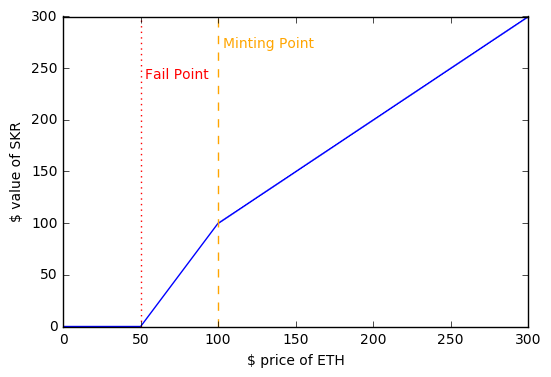

In [9]:
# if half of SKR is held in CDPs:

eth_in_pool = 2
initial_SKR = 2
initial_SKR_in_CDP = 1

plot_SKR_value()

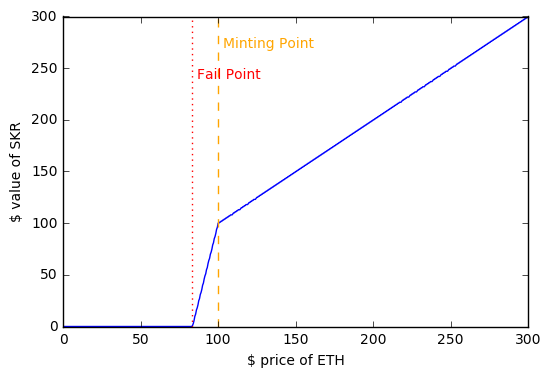

In [10]:
# if most (83%) of SKR is held in CDPs:

eth_in_pool = 1.2
initial_SKR = 1.2
initial_SKR_in_CDP = 1

plot_SKR_value()

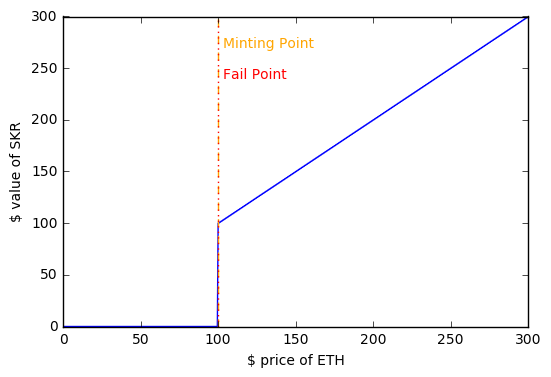

In [11]:
# if all SKR is held in CDPs:

eth_in_pool = 1
initial_SKR = 1
initial_SKR_in_CDP = 1

plot_SKR_value()